### Spice curvature

Scherbina et al 2009 showed that the spice curvature ($\tau_{\sigma \sigma}$) is a useful measure to look at the layering. Strong diapycnal diffusivity would erode this quantity, so if we have high values it is suggestive of recent layering. Small value can be a result of age of strong mixing in the mixed layer.  

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [2]:
ds_660_rho = xr.open_dataset('data/ctd_O2_660_isopycnal_grid_4m_22_sept_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (alpha*dCT + beta*dSA).rename('Spice')

Being a second derivative this quantity is hard to estimate. We need to do some filtering to remove the smallest signals. So we test different filtering scales (rolling means), and choose something slightly arbitrarily. 

In [4]:
filts = np.array([5,10, 15,20 ,25, 30, 35, 40 ,50,70,80, 90, 100])
temp = np.zeros((len(filts),))
n=0
for i in filts:
    spice_rho_rho = (ds_660_rho.Spice.rolling(rho_grid=i, center=True).mean()).rolling(rho_grid=i, center=True).mean().diff('rho_grid').diff('rho_grid')/0.001**2
    temp[n] = (spice_rho_rho.sel(rho_grid=slice(27.3, 27.9)).std())
    n=n+1

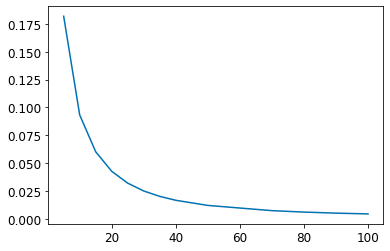

In [5]:
plt.plot(filts, temp)
#plt.yscale('log')

In [6]:
i=30
spice_rho_rho = (ds_660_rho.Spice.rolling(rho_grid=i, center=True).mean()).rolling(rho_grid=i, center=True).mean().diff('rho_grid').diff('rho_grid')/0.001**2

(27.9, 27.25)

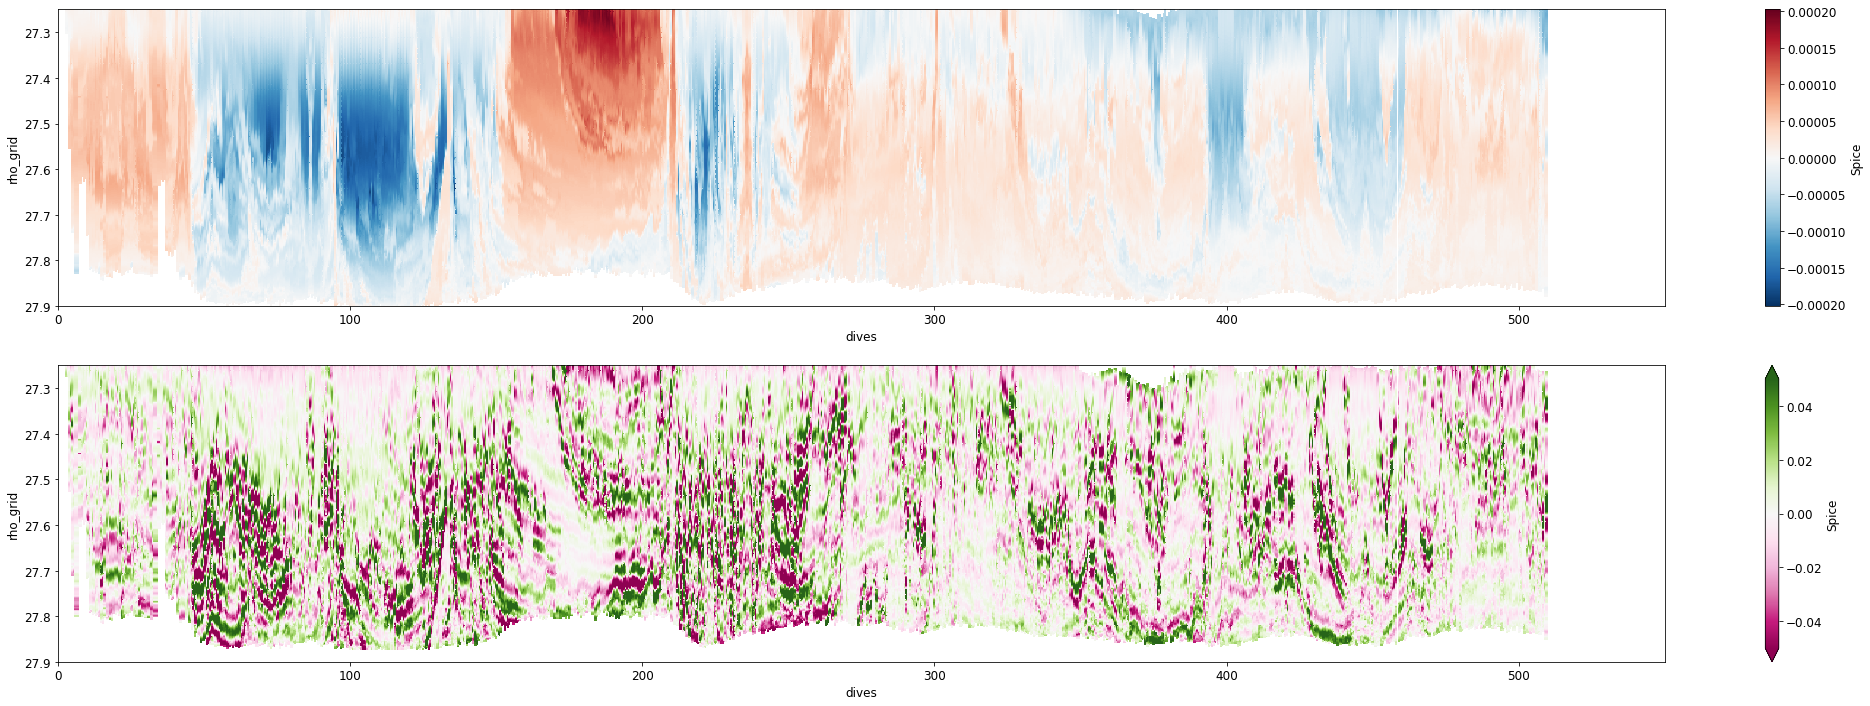

In [7]:
xlim = [0, 550]
ylim = [27.9, 27.25]
plt.figure(figsize=(36,12))

plt.subplot(211)
ds_660_rho.Spice.plot()
plt.gca().invert_yaxis()
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(212)
spice_rho_rho.plot(vmin=-.05, cmap='PiYG')
plt.gca().invert_yaxis()
plt.xlim(xlim)
plt.ylim(ylim)

In [165]:
Pmean_smooth = ds_660_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean()

In [166]:
from scipy import interpolate
def func_var_int_pmean(ds): 
    Pmean_grid = np.linspace(0,1000,501)
    
    #ds = ds[var]
    
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'dives'],
                        coords = {'Pmean': Pmean_grid, 'dives': [ds.dives.values]})
    

In [168]:
# Interpolate to iso
dive_ind=0
spice_curve_on_Pmean = func_var_int_pmean(spice_rho_rho.isel(dives=dive_ind))

for dive_ind in range(1, len(spice_rho_rho.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_curve_on_Pmean = xr.concat([spice_curve_on_Pmean, 
                                func_var_int_pmean(spice_rho_rho.isel(dives=dive_ind))]
                              , dim='dives')
    

100
200
300
400
500
600
700
800
900
1000


(27.9, 27.25)

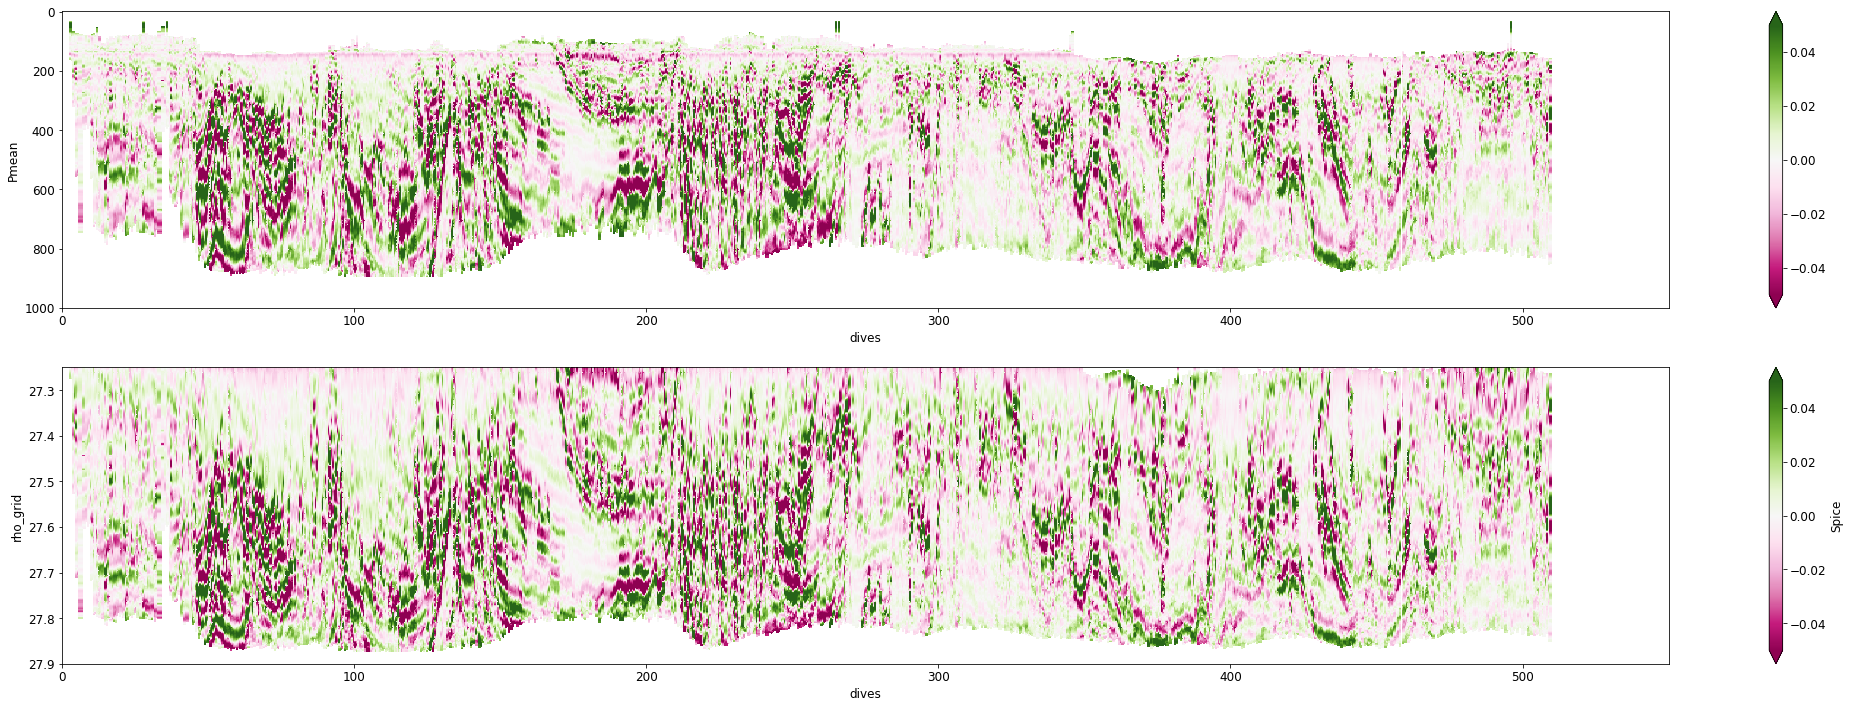

In [185]:
plt.figure(figsize=(36,12))

plt.subplot(211)
spice_curve_on_Pmean.plot(vmin=-0.05, cmap='PiYG')
plt.gca().invert_yaxis()
plt.xlim(xlim)

plt.subplot(212)
spice_rho_rho.plot(vmin=-.05, cmap='PiYG')
plt.gca().invert_yaxis()
plt.xlim(xlim)
plt.ylim(ylim)

The main conclusions are: 
- The spice curvature does highlight the layering a little better. 
- The watermasses that are in the cold blobs (we think recently ventilated based on O2 signal) also have very little layering. 
- There is also a low layering zone in some of the hot waters, maybe suggestive of old waters. 
- In contrast to other regions the layering extends all the way to the bottom of the survey. 

Might be a little more useful to plot this in terms of distance. 

In [187]:
lon = ds_660_rho.longitude.sel(rho_grid=27.5, method='nearest')
lat = ds_660_rho.latitude.sel(rho_grid=27.5, method='nearest')

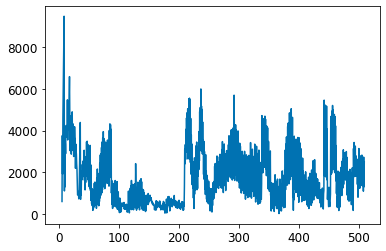

In [190]:
plt.plot(ds_660_rho.dives, gt.utils.distance(lon, lat))